# Feed Forward Neural Network 

You need to have these three files to run all the cells in this notebook
1. ITClust train dataset
2. ITClust test dataset
3. FlowGMM codebase zip 

In [1]:
all_batches_file = '/home/anunay18021/SingleCellClassification/dataset/adata_pbmc_batches_raw.h5ad'

In [2]:
# Call Libraries
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch import distributions
import sys
sys.path.insert(0, '')
from scripts.utils import *
import numpy as np
torch.manual_seed(0)
np.random.seed(0)
import scanpy as sc
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
import os
from numpy.random import seed
# from tensorflow import set_random_seed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle
import sys

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.dpi'] = 100

# from flow_ssl.realnvp.realnvp_toy import ToyRealNVP
from flow_ssl.realnvp.realnvp import RealNVPTabular
from flow_ssl.data import make_circles_ssl, make_moons_ssl, make_dataset_from_img, make_dataset_from_npz
from flow_ssl.distributions import SSLGaussMixture
from flow_ssl import FlowLoss

from itertools import chain

%load_ext autoreload
%autoreload 2

/home/anunay18021/.venv/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/anunay18021/.venv/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/anunay18021/.venv/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWa

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 pynndescent==0.5.10


/home/anunay18021/.venv/lib/python3.8/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [3]:
adata = sc.read(all_batches_file)

/home/anunay18021/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/anunay18021/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")



____Create unique index____ 
normalizing counts per cell
    finished (0:00:10)


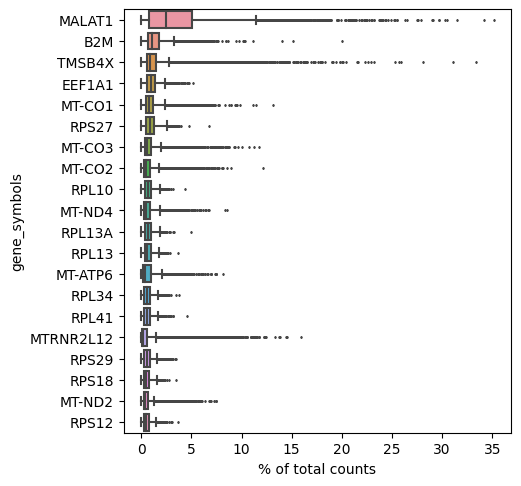

____Filtering the data____
pre filtering: (30495, 33694)
filtered out 2035 cells that have less than 200 genes expressed
filtered out 9096 genes that are detected in less than 3 cells
post filtering: (28460, 24598)
____Log normalizing____
normalizing counts per cell
    finished (0:00:01)
____Selecting highly variable genes____
pre: (28460, 24598)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
pre: (28460, 24598)


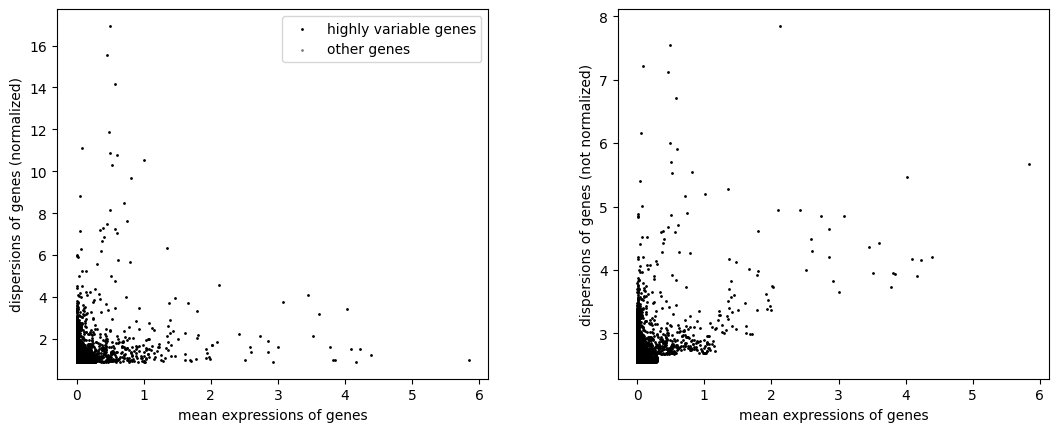

post: (28460, 3000)
____Scaling the data____


/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


gene_symbols,SCYL3,FUCA2,TMEM176A,HSPB6,PDK4,SLC22A16,ARX,SLC25A13,SLC4A1,THSD7A,...,CH17-262H11.1,TRBJ1-5,RP11-328P23.4,CH17-212P11.4,CH17-224D4.1,RP11-596C23.6,CTC-490G23.6,PRNCR1,RP1-273N12.4,TRBV6-2
pbmc1_Celseq2_1_ACAGAC,-0.210501,2.240501,-0.133715,-0.017045,-0.092075,-0.022733,-0.017383,-0.148193,2.772827,-0.018138,...,-0.016476,-0.037941,-0.019149,-0.009174,-0.018344,-0.035799,-0.009078,-0.125148,-0.020136,-0.046757
pbmc1_Celseq2_1_ACAGGA,1.656750,2.347928,-0.133715,-0.017045,-0.092075,-0.022733,-0.017383,-0.148193,-0.130104,-0.018138,...,-0.016476,-0.037941,-0.019149,-0.009174,-0.018344,-0.035799,-0.009078,-0.125148,-0.020136,-0.046757
pbmc1_Celseq2_1_ACGTTG,-0.210501,-0.162299,-0.133715,-0.017045,-0.092075,-0.022733,-0.017383,-0.148193,-0.130104,-0.018138,...,-0.016476,-0.037941,-0.019149,-0.009174,-0.018344,-0.035799,-0.009078,-0.125148,-0.020136,-0.046757
pbmc1_Celseq2_1_AGACCA,-0.210501,-0.162299,-0.133715,-0.017045,-0.092075,-0.022733,-0.017383,-0.148193,-0.130104,-0.018138,...,-0.016476,-0.037941,-0.019149,-0.009174,-0.018344,-0.035799,-0.009078,-0.125148,-0.020136,-0.046757
pbmc1_Celseq2_1_CAACTC,-0.210501,-0.162299,-0.133715,-0.017045,-0.092075,-0.022733,-0.017383,-0.148193,-0.130104,-0.018138,...,-0.016476,-0.037941,-0.019149,-0.009174,-0.018344,-0.035799,-0.009078,-0.125148,-0.020136,-0.046757


In [4]:

print("\n____Create unique index____ ")
adata.var_names_make_unique()
sc.pl.highest_expr_genes(adata, n_top=20, )
        
print("____Filtering the data____")
print("pre filtering:",adata.shape)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
print("post filtering:",adata.shape)

print("____Log normalizing____")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

print("____Selecting highly variable genes____")
print("pre:",adata.shape)
sc.pp.highly_variable_genes(adata, min_mean=0.001 , max_mean=3, min_disp=0.3, n_top_genes=3000)
print("pre:",adata.shape)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pl.highly_variable_genes(adata)
print("post:",adata.shape)

print("____Scaling the data____")
sc.pp.scale(adata, max_value=10)
adata.to_df().head()

In [5]:
all_batches = list(set(adata.obs.Method.values))

In [6]:
all_batches

['10x Chromium (v3)',
 'CEL-Seq2',
 'Drop-seq',
 '10x Chromium (v2) B',
 '10x Chromium (v2)',
 '10x Chromium (v2) A',
 'Seq-Well',
 'inDrops']

In [7]:
batch_name = 'Seq-Well'

In [8]:
mapping = {}
reverse_mapping = {}
cnt = 0
for i in set(adata.obs.CellType.values):
    mapping[i] = cnt
    reverse_mapping[cnt] = i
    cnt += 1

In [9]:
total_classes = len(set(adata.obs.CellType.values))

# One vs all for batch '10x Chromium (v2) B'

In [10]:
train_df = adata[adata.obs['Method'] != batch_name].to_df()
test_df = adata[adata.obs['Method'] == batch_name].to_df()

In [11]:
print("Taking common genes...")
final_columns = list(set(train_df.columns).intersection(set(test_df.columns)))
print('Common columns', len(final_columns))
final_columns = [i for i in final_columns if i != 'CellType'] 
train_df = train_df[final_columns]
test_df = test_df[final_columns]

y_train = adata[adata.obs['Method'] != batch_name].obs.CellType.to_list()
y_test = adata[adata.obs['Method'] == batch_name].obs.CellType.to_list()

X_train = train_df.to_numpy()
X_test = test_df.to_numpy()

Taking common genes...
Common columns 3000


In [12]:
y_test_lab = convert_y_to_mapping(y_test, mapping)
y_test_lab = np.array(y_test_lab)

y_train_lab = convert_y_to_mapping(y_train, mapping)
y_train_lab = np.array(y_train_lab)

In [13]:
with open('/home/anunay18021/SingleCellClassification/dataset/np/X_train_'+batch_name+'.pkl', 'wb') as fh:
        pickle.dump(X_train, fh)

with open('/home/anunay18021/SingleCellClassification/dataset/np/X_test_'+batch_name+'.pkl', 'wb') as fh:
    pickle.dump(X_test, fh)

with open('/home/anunay18021/SingleCellClassification/dataset/np/y_test_'+batch_name+'.pkl', 'wb') as fh:
    pickle.dump(y_test_lab, fh)

with open('/home/anunay18021/SingleCellClassification/dataset/np/y_train_'+batch_name+'.pkl', 'wb') as fh:
    pickle.dump(y_train_lab, fh)

In [14]:
len(y_train_lab)

25116

In [15]:
%cd flowgmm

/home/anunay18021/SingleCellClassification/flowgmm


In [16]:
!python3 experiments/train_flows/flowgmm_tabular_new.py --num_classes 10 --metric_name "Seq-Well" --trainer_config "{'unlab_weight':.6}" --net_config "{'k':1024,'coupling_layers':7,'nperlayer':1}" --network RealNVPTabularWPrior --trainer SemiFlow --num_epochs 500 --dataset AG_News --lr 3e-4 --train 200

{'num_classes': 10, 'metric_name': 'Seq-Well', 'dataset': <class 'flow_ssl.data.nlp_datasets.AG_News'>, 'network': <function RealNVPTabularWPrior at 0x7f1b7798bdc0>, 'num_epochs': 500, 'bs': 5000, 'lr': 0.0003, 'optim': <class 'torch.optim.adamw.AdamW'>, 'device': 'cuda', 'trainer': SemiFlow, 'split': {'train': 200, 'val': 5000}, 'net_config': {'k': 1024, 'coupling_layers': 7, 'nperlayer': 1}, 'opt_config': {'weight_decay': 1e-05}, 'trainer_config': {'log_dir': '/home/anunay18021/tb-experiments/UCI/', 'log_args': {'minPeriod': 0.1, 'timeFrac': 0.3}, 'unlab_weight': 0.6}, 'save': False}
Seq-Well
25116
25116
3344
Pairwise dists: [[ 0.         43.26609407 43.29821386 43.37894322 43.38489296 42.52338116
  43.32521309 42.7396277  42.54512044 42.63468641]
 [43.26609407  0.         42.90046927 43.06665889 43.1685962  43.89246336
  43.18936002 43.29689437 43.11490918 43.14754915]
 [43.29821386 42.90046927  0.         42.75266514 43.41320231 43.91987738
  43.6646075  43.37605235 43.71957295 43.

In [17]:
with open("/home/anunay18021/SingleCellClassification/tmp/metrics_" + batch_name + ".pkl", "rb") as f:
  D = pickle.load(f)

In [18]:
rev = list(mapping.keys())
new_D = {}
for i in D:
  try:
    new_D[reverse_mapping[int(i.split("_")[-1])]] = D[i]
  except:
    continue

In [19]:
plt.rcParams["figure.figsize"] = (20,5.5)

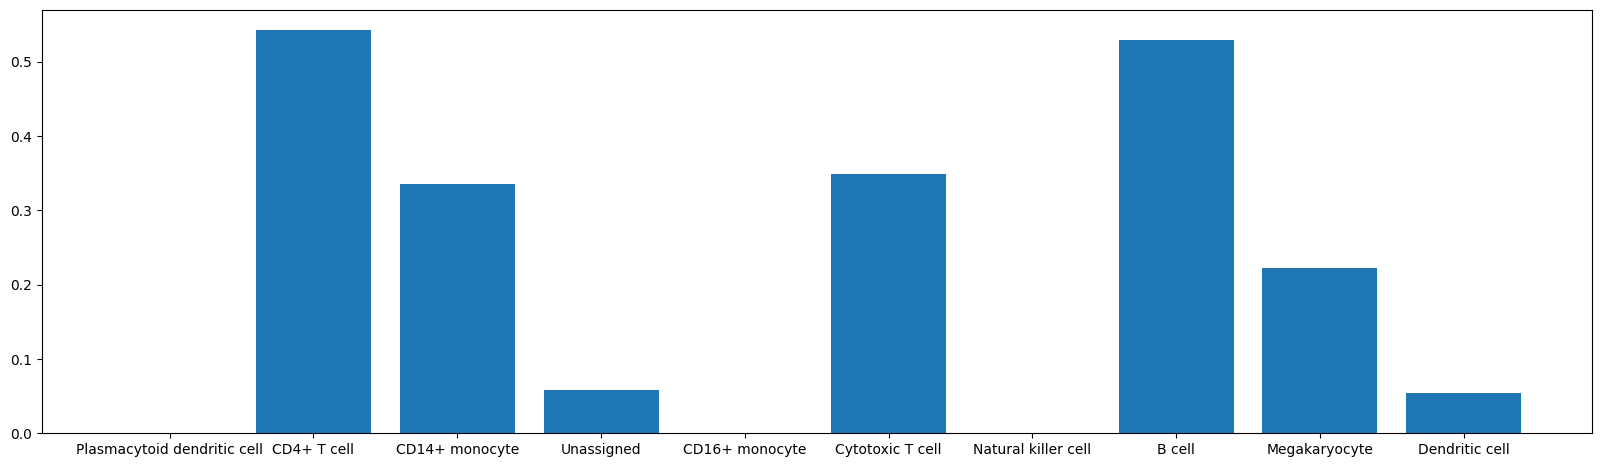

In [20]:
plt.bar(range(len(new_D)), list(new_D.values()))
plt.xticks(range(len(new_D)), list(new_D.keys()))
plt.show()

In [21]:
classes_labeled = {}
for i in D:
  try:
        classes_labeled[reverse_mapping[int(i.split("_")[-1])]] = D[i]
  except:
        classes_labeled[i] = D[i]

In [22]:
df = pd.DataFrame(columns = list(classes_labeled.keys()))

In [23]:
df.append(classes_labeled, ignore_index = True)

/tmp/ipykernel_340255/3840281218.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(classes_labeled, ignore_index = True)


,val_bpd,Train_Acc,val_Acc,test_Acc,Plasmacytoid dendritic cell,CD4+ T cell,CD14+ monocyte,Unassigned,CD16+ monocyte,Cytotoxic T cell,Natural killer cell,B cell,Megakaryocyte,Dendritic cell
0,4.764566,0.959774,0.839968,0.395335,0.0,0.542495,0.334787,0.058824,NaN,0.349282,NaN,0.529528,0.222222,0.054054
